Class for NAND-CIRC programming language

In [102]:
from math import log, floor

In [103]:
def int2bin(n, num_bits = None, least_sig_first = True):
        if num_bits == None:
            if n == 0:
                return '0'
            else:
                num_bits = floor(log(n, 2) + 1)
        s = bin(n)[2:]
        len_s = len(s)
        if len_s > num_bits:
            raise Exception('Decimal {} cannot be represented with {} bits'.format(n, num_bits))
        elif len_s < num_bits:
            s = '0'*(num_bits - len_s) + s
        if least_sig_first:
            return ''.join(reversed(s))
        else:
            return s
def bin2int(s, least_sig_first = True):
    if s == '':
        return 0
    if not least_sig_first:
        s = ''.join(reversed(s))
    return int(s[0]) + 2 * bin2int(s[1:])
def NAND(a, b):
    if a != 0 and a != 1:
        raise Exception('NAND input {}, expecting 0 or 1'.format(a))
    if b != 0 and b!= 1:
        raise Exception('NAND input {}, expecting 0 or 1'.format(b))
    return 1 - a * b

In [104]:
class NAND_CIRC:
    def __init__(self, num_inputs : int, num_outputs : int):
        if num_inputs < 1 or num_outputs < 1:
            raise Exception('Cannot create nontrivial circuit with {} inputs and {} outputs'.format(num_inputs, num_outputs))
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_working = 0
        self.valued_vars = []
        for i in range(num_inputs):
            self.valued_vars.append('X[{}]'.format(i))
        self.program = []
        
    def allocate(self):
        w = 'W[{}]'.format(self.num_working)
        self.num_working += 1
        return w
    
    def input_var(self, i):
        n = self.num_inputs
        if i >= n:
            raise Exception('This program only has {} input variables'.format(n))
        return 'X[{}]'.format(i)
    
    def output_var(self, i):
        m = self.num_outputs
        if i >= m:
            raise Exception('This program only has {} output variables'.format(m))
        return 'Y[{}]'.format(i)
            
    def is_w(var):
        return var[0] == 'W'
    
    def is_x(var):
        return var[0] == 'X'
    
    def is_y(var):
        return var[0] == 'Y'
        
    def index(var):
        return int(var[2:-1])
    
    def check_format(var):
        if len(var) < 4:
            formatted = False
        else:
            formatted = (var[1] == '[' and var[-1] == ']') and (NAND_CIRC.is_w(var) or NAND_CIRC.is_x(var) or NAND_CIRC.is_y(var))
            try:
                NAND_CIRC.index(var)
            except:
                formatted = False
        if not formatted:
            raise Exception('NAND variable {} is improperly formatted'.format(var))
        
    def check_index(self, var):
        i = NAND_CIRC.index(var)
        if NAND_CIRC.is_w(var) and i >= self.num_working:
            raise Exception('Program has {} working variables: NAND variable {} is out of range'.format(self.num_working, var))
        if NAND_CIRC.is_x(var) and i >= self.num_inputs:
            raise Exception('Program has {} input variables: NAND variable {} is out of range'.format(self.num_inputs, var))
        if NAND_CIRC.is_y(var) and i >= self.num_outputs:
            raise Exception('Program has {} output variables: NAND variable {} is out of range'.format(self.num_outputs, var))
        
    def check_input(self, inz):
        if NAND_CIRC.is_y(inz):
            raise Exception('NAND input variable {} cannot be one of the program\'s output variables'.format(inz))
        if inz not in self.valued_vars:
            raise Exception('NAND input variable {} is not a function of the program\'s input variables'.format(inz))
    
    def check_output(self, out):
        if NAND_CIRC.is_x(out):
            raise Exception('NAND output variable {} cannot be one of the program\'s input variables'.format(out))
        if out in self.valued_vars:
            raise Exception('NAND output variable {} is already the output of another NAND gate'.format(out))
        
    def NAND(self, out, in0, in1):
        triple = (out, in0, in1)
        [NAND_CIRC.check_format(z) for z in triple]
        [self.check_index(z) for z in triple]
        self.check_input(in0)
        self.check_input(in1)
        self.check_output(out)
        self.valued_vars.append(out)
        self.program.append(triple)
    
    def NOT(self, out, in0):
        self.NAND(out, in0, in0)
    
    def AND(self, out, in0, in1):
        temp = self.allocate()
        self.NAND(temp, in0, in1)
        self.NOT(out, temp)
    
    def OR(self, out, in0, in1):
        not_0 = self.allocate()
        self.NOT(not_0, in0)
        not_1 = self.allocate()
        self.NOT(not_1, in1)
        self.NAND(out, not_0, not_1)
    
    def IF(self, out, cond, in0, in1):
        notcond = self.allocate()
        self.NOT(notcond, cond)
        temp_0 = self.allocate()
        self.NAND(temp_0, in0, cond)
        temp_1 = self.allocate()
        self.NAND(temp_1, in1, notcond)
        self.NAND(out, temp_0, temp_1)
    
    def ONE(self, out):
        in0 = self.input_var(0)
        temp = self.allocate()
        self.NOT(temp, in0)
        self.NAND(out, temp, in0)
    
    def ZERO(self, out):
        temp = self.allocate()
        self.ONE(temp)
        self.NOT(out, temp)
    
    def num_vars(self):
        counter = self.num_inputs + self.num_outputs
        for triple in self.program:
            out, _, _ = triple
            if NAND_CIRC.is_w(out):
                counter += 1
        return counter
    
    def var_length(self):
        return len(int2bin(self.num_vars() - 1))
    
    def index_program(self):
        n = self.num_vars()
        w_seen = {}
        w_counter = [self.num_inputs]
        def f(var):
            if NAND_CIRC.is_w(var):
                if var not in w_seen:
                    w_seen[var] = w_counter[0]
                    w_counter[0] += 1
                return w_seen[var]
            elif NAND_CIRC.is_x(var):
                return NAND_CIRC.index(var)
            else:
                return n - self.num_outputs + NAND_CIRC.index(var)
        p = []
        for triple in self.program:
            p.append(tuple([f(var) for var in triple]))
        return p
    
    def circ2str(self):
        var_len = self.var_length()
        b = lambda x : int2bin(x, var_len)
        prefix = ''
        for char in int2bin(var_len):
            prefix += 2*char
        s = prefix + '01'
        s += b(self.num_inputs)
        s += b(self.num_outputs)
        for triple in self.index_program():
            out, in0, in1 = triple
            s += b(out)
            s += b(in0)
            s += b(in1)
        return s

In [105]:
def split(s, i):
    return s[0:i], s[i:]

def check_str(s):
    t = type(s)
    if t != str:
        raise Exception('Invalid string: {} is of type {}, expecting type str'.format(s, t))
    for b in s:
        if b != '0' and b != '1':
            raise Exception('Invalid string: {} contains the character {}, expecting 0 or 1'.format(s, b))

def get_prefix(p):
    i = 0
    prefix = 0
    while True:
        if p[2 * i] == p[2 * i + 1]:
            prefix += int(p[2 * i]) * 2 ** i
            i += 1
        else:
            i += 1
            break
    p = p[2 * i:]
    return prefix, p
def 

In [151]:
def EVAL_CIRC(p, x):
    full_p = p
    check_str(p), check_str(x)
    invalid_encoding = 'Invalid NAND-CIRC encoding: {}'.format(full_p)
    if p[0] != p[1]:
        raise Exception(invalid_encoding)
    var_len, p = get_prefix(p)
    if len(p) < var_len * 2:
        raise Exception(invalid_encoding)
    num_inputs, p = split(p, var_len)
    num_outputs, p = split(p, var_len)
    num_inputs, num_outputs = bin2int(num_inputs), bin2int(num_outputs)
    if len(p) % (var_len * 3) != 0:
        raise Exception(invalid_encoding)
    if len(x) != num_inputs:
        raise Exception('Program {} takes inputs of length {}, input {} is of length {}'.format(full_p, num_inputs, x, len(x)))
    vars = {}
    b = lambda i : int2bin(i, var_len)
    for i in range(num_inputs):
        vars[b(i)] = int(x[i])
    while p != '':
        out, p = split(p, var_len)
        in0, p = split(p, var_len)
        in1, p = split(p, var_len)
        vars[out] = NAND(vars[in0], vars[in1])
    output = ''
    num_vars = len(vars)
    for i in range(num_vars - num_outputs, num_vars):
        output += str(vars[b(i)])
    return output

In [117]:
def LOOKUP(k):
    num_inputs = 2 ** k + k
    p = NAND_CIRC(num_inputs, 1)
    if k <= 0:
        raise Exception('Input {} must be at least 1 to create non-trivial NAND-CIRC program'.format(k))
    IF_inputs = [p.input_var(i) for i in range(2 ** k)]
    for i in range(k - 1):
        cond = p.input_var(num_inputs - i - 1)
        next_IF_inputs = []
        for j in range(int(len(IF_inputs) / 2)):
            out = p.allocate()
            p.IF(out, cond, IF_inputs[2 * j + 1], IF_inputs[2 * j])
            next_IF_inputs.append(out)
        IF_inputs = next_IF_inputs
    out = p.output_var(0)
    cond = p.input_var(num_inputs - k)
    p.IF(out, cond, IF_inputs[1], IF_inputs[0])
    return p.circ2str()

In [118]:
def OUT2CIRC(output_list):
    num_outputs = len(output_list[0])
    for output in output_list:
        check_str(output)
        if len(output) != num_outputs:
            raise Exception('All outputs {} must be of the same length'.format(output_list))
    num_inputs = len(int2bin(len(output_list) - 1))
    for i in range(2 ** num_inputs - len(output_list)):
        output_list.append('0'* num_outputs)
    p = NAND_CIRC(num_inputs, num_outputs)
    flipped_output_list = [['' for _ in range(2 ** num_inputs)] for _ in range(num_outputs)]
    for i in range(num_outputs):
        for j in range(2 ** num_inputs):
            b = output_list[j][i]
            temp = p.allocate()
            if b == '0':
                p.ZERO(temp)
            else:
                p.ONE(temp)
            flipped_output_list[i][j] = temp
    for i in range(num_outputs):
        IF_inputs = flipped_output_list[i]
        for j in range(num_inputs - 1):
            cond = p.input_var(num_inputs - j - 1)
            next_IF_inputs = []
            for k in range(int(len(IF_inputs) / 2)):
                out = p.allocate()
                p.IF(out, cond, IF_inputs[2 * k + 1], IF_inputs[2 * k])
                next_IF_inputs.append(out)
            IF_inputs = next_IF_inputs
        out = p.output_var(i)
        cond = p.input_var(0)
        p.IF(out, cond, IF_inputs[1], IF_inputs[0])
    return p.circ2str()

In [ ]:
def remove_duplicates(lst):
    res = []
    for elt in lst:
        if elt not in res:
            res.append(elt)
    return res

In [1]:
class NAND_TM:
    def __init__(self, state_list : list, alphabet : list, transition_table : dict):
        """"
        - The first state of the user-specified state list will be taken as the initial state.
        - The first symbol of the user-specified alphabet will be taken as the start symbol.
        - The second symbol of the user-specified alphabet will be taken as the empty set symbol.
        - The transition table will be a dictionary wherein each key is a tuple with the first element being a
          state in the state list and the second being a symbol in the alphabet. The value at each key is a tuple
          with the first element being the direction L, R, H, or S, the second element being the new state, and the
          third element being the new symbol in the alphabet to be written on the tape.
        """
        
        state_list = remove_duplicates(state_list)
        alphabet = remove_duplicates(alphabet)
        
        for state in state_list:
            for symbol in alphabet:
                if (state, symbol) in transition_table:
                    new_state, new_symbol, direction = transition_table[(state, symbol)]
                    if direction not in ['L', 'R', 'S', 'H']:
                        raise Exception('Transition table {} does not have a valid direction for input {} * {}'.format(transition_table, state, symbol))
                    if new_state not in state_list:
                        raise Exception('Transition table {} does not have a valid new state for input {} * {}'.format(transition_table, state, symbol))
                    if new_symbol not in alphabet:
                        raise Exception('Transition table {} does not have a valid new symbol for input {} * {}'.format(transition_table, state, symbol))
                else:
                    raise Exception('Transition table {} does not cover all possible state * symbol inputs'.format(transition_table))
        
        self.state_list = state_list
        self.alphabet = alphabet
        self.transition_table = transition_table
                
        self.num_states = len(state_list)
        self.num_symbols = len(alphabet)
        self.num_pairs = len(int2bin(self.num_states * self.num_symbols - 1))
        
        self.state_len = len(int2bin(self.num_states - 1))
        self.symbol_len = len(int2bin(self.num_symbols - 1))
        self.pair_len = len(int2bin(self.num_pairs - 1))

    directions = ['L','R','S','H']

    def check_state(self, state):
        if state not in self.state_list:
            raise Exception('Input state {} is not in state list {}'.format(state, self.state_list))
    
    def check_symbol(self, symbol):
        if symbol not in self.alphabet:
            raise Exception('Input symbol {} is not in alphabet {}'.format(symbol, self.alphabet))
    
    def state_index(self, state):
        self.check_state(state)
        return self.state_list.index(state)
    
    def symbol_index(self, symbol):
        self.check_symbol(symbol)
        return self.alphabet.index(symbol)
    
    def pair_index(self, state, symbol):
        return self.state_index(state) * len(self.alphabet) + self.symbol_index(symbol)
    
    def direction_index(direction):
        if direction not in NAND_TM.directions:
            raise Exception('Invalid direction: {}, expecting L, R, S, H'.format(direction))
        return NAND_TM.directions.index(direction)
    
    def get_state(self, index):
        return self.state_list[index]
        
    def get_symbol(self, index):
        return self.alphabet[index]
    
    def get_pair(self, index):
        state_index = floor((index / self.num_symbols))
        symbol_index = index - state_index * self.num_symbols
        return (self.get_state(state_index), self.get_symbol(symbol_index))
    
    def tape2str(tape):
        res = []
        for symbol in tape:
            self.check_symbol(symbol)
            res.append(int2bin(self.symbol_index(symbol), self.symbol_len))
            
    def str2tape(s):
        res = [self.alphabet[0]]
        str_len = len(s)
        symbol_len = self.symbol_len
        if str_len % symbol_len != 0:
            raise Exception('Length of string {} is not a multiple of the symbol length {}'.format(str_len, symbol_len))
        for i in range(int(str_len / symbol_len)):
            symbol_index = s[symbol_len * i : symbol_len * (i + 1)]
            res.append(self.get_symbol(symbol_index))
        return res
    """"
    def transition2str(self):
        output_list = []
        for i in range(self.num_pairs):
            state, symbol = self.get_pair(i)
            new_state, new_symbol, direction = self.transition_table[(state, symbol)]
            new_pair = int2bin(self.pair_index(new_state, new_symbol), self.pair_len)
            direction = int2bin(NAND_TM.direction_index(direction), 2)
            output_list.append(new_pair + direction)
        return output_list
    
    def transition2str(self):
        output_list = ['0' * self.state_len + self.symbol_len + 2 for _ in range(2 ** (self.state_len + self.symbol_len))]
        for state in self.state_list:
            for symbol in self.alphabet:
                state_str = int2bin(self.state_index(state), self.state_len)
                symbol_str = int2bin(self.symbol_index(symbol), self.symbol_len)
                index = bin2int(state_str + symbol_str)
                new_state, new_symbol, direction = self.transition_table[(state, symbol)]
                new_state_str = int2bin(self.state_index(new_state), self.state_len)
                new_symbol_str = int2bin(self.symbol_index(new_symbol), self.symbol_len)
                direction_str = int2bin(self.direction_index(direction), 2)
                output_list[index] = new_state_str + new_symbol_str + direction_str
        return output_list   
     """           
    def tm2str(self):
        prefix = ''
        for b in int2bin(self.num_states):
            prefix += b * 2
        prefix += '01'
        for b in int2bin(self.num_symbols):
            prefix += b * 2
        prefix += '01'
        output_list = []
        for i in range(self.num_pairs):
            state, symbol = self.get_pair(i)
            new_state, new_symbol, direction = self.transition_table[(state, symbol)]
            new_pair = int2bin(self.pair_index(new_state, new_symbol), self.pair_len)
            direction = int2bin(NAND_TM.direction_index(direction), 2)
            output_list.append(new_pair + direction)
        transition_str = ''
        for output in output_list:
            transition_str += output
        return prefix + transition_str
    
    def EVAL(self, x):
        output_list = []
        for i in range(self.num_pairs):
            state, symbol = self.get_pair(i)
            new_state, new_symbol, direction = self.transition_table[(state, symbol)]
            new_pair = int2bin(self.pair_index(new_state, new_symbol), self.pair_len)
            direction = int2bin(NAND_TM.direction_index(direction), 2)
            output_list.append(new_pair + direction)
        transition_circ = OUT2CIRC(output_list)
        head_position = 0
        x.insert(0, self.get_symbol(0))
        state = self.get_state(0)
        while True:
            if head_position >= len(x):
                x.append(self.get_symbol(1))
            symbol = x[head_position]
            pair = self.pair_index(state, symbol)
            out = EVAL_CIRC(transition_circ, int2bin(pair, self.pair_len))
            new_pair, direction = split(out, self.pair_len)
            direction = NAND_TM.directions[int2bin(direction, 2)]
            new_state, new_symbol = self.get_pair(int2bin(new_pair, self.pair_len))
            x[i] = new_symbol
            state = new_state
            if direction == 'L':
                head_position -= 1
            elif direction == 'R':
                head_position += 1
            elif direction == 'S':
                continue
            else:
                break
        return x[1:]

In [2]:
def EVAL_TM(p, x):
    check_str(p), check_str(x)
    invalid_encoding = 'Invalid NAND-TM encoding: {}'.format(p)
    if p[0] != p[1]:
        raise Exception(invalid_encoding)
    num_states, p = get_prefix(p)
    num_symbols, transition_str = get_prefix(p)
    num_pairs = num_states * num_symbols
    state_len = len(int2bin(num_states - 1))
    symbol_len = len(int2bin(num_symbols - 1))
    pair_len = len(int2bin(num_pairs - 1))
    
    transition_table = ['0' * (pair_len + 2) for _ in range(num_pairs)]
    for i in range(len(transition_table)):
        state_index = floor((i / num_symbols))
        symbol_index = i - state_index * num_symbols
        
        s = int2bin(i, state_len + symbol_len)
        in_state_str, in_symbol_str = split(s, state_len)
        in_state_index, in_symbol_index = bin2int(state_str), bin2int(symbol_str)
        if in_state_index >= num_states or in_symbol_index >= num_symbols:
            continue
        in_pair_index = in_state_index * num_symbols + in_symbol_index
        out_str = transition_str[(pair_len + 2) * pair_index : (pair_len + 2) * (pair_index + 1)]
        out_pair_str, direction_str = split(out_str, pair_len)
        out_pair_index = bin2int(out_pair_str)
        out_state_index = floor(out_pair_index / num_symbols)
        out_symbol_index = out_pair_index - out_state_index * num_symbols
        out_state_str, out_symbol_str = int2bin(out_state_index, state_len), int2bin(out_symbol_index, symbol_len)
        transition_table[i] = out_state_str + out_symbol_str + direction_str
    transition_CIRC = OUT2CIRC(transition_table)    
    tape = ['0' * symbol_len]
    if len(x) % symbol_len != 0:
        raise Exception('Length of input {} is not divisible by symbol length {}'.format(x, symbol_len))
    for i in range(int(len(x) / symbol_len)):
        tape.append(x[symbol_len * i : symbol_len * (i + 1)])
    head_position = 0
    state = '0' * state_len
    directions = ['L', 'R', 'S', 'H']
    while True:
        symbol = tape[head_position]
        out = EVAL_CIRC(transition_CIRC, state + symbol)
        state, temp = split(out, state_len)
        symbol, direction = split(temp, symbol_len)
        tape[head_position] = symbol
        letter = directions[bin2int(direction)]
        if letter == 'L':
            head_position -= 1
        elif letter == 'R':
            head_position += 1
        elif letter == 'H':
            break
    return output

In [153]:
p = NAND_CIRC(2,1)
print(p.program)

[]


In [155]:
a = p.allocate()
b = p.allocate()
b = p.allocate()
print(a)

W[0]


In [156]:
p.NAND(a, p.input_var(0), p.input_var(1))
p.NAND(b, a, p.input_var(0))
p.NAND(p.output_var(0), a, b)
print(p.program)


[('W[0]', 'X[0]', 'X[1]'), ('W[2]', 'W[0]', 'X[0]'), ('Y[0]', 'W[0]', 'W[2]')]


In [157]:
p.index_program()

[(2, 0, 1), (3, 2, 0), (4, 2, 3)]

In [158]:
s = p.circ2str()

In [159]:
x = '10'
EVAL_CIRC(s, x)

'1'

In [160]:
p = NAND_CIRC(3, 1)
p.IF(p.output_var(0), p.input_var(0), p.input_var(1), p.input_var(2))
s = p.circ2str()
x = '110'
EVAL_CIRC(s, x)

'1'

In [161]:
LOOKUP(2)

'110011010110010000011001010010100111001000010100000100000001100100101110000010010101010010100110101100010100001100100001010101101101000110011100010000100111101011000100000011001001110100011111000001'

In [163]:
EVAL_CIRC(s, '001')

'1'

In [164]:
[1].copy()

[1]

In [166]:
p = NAND_CIRC(1,1)
p.ZERO(p.output_var(0))
s = p.circ2str()
EVAL_CIRC(s, '0')

'0'

In [168]:
k = 3
p = LOOKUP(k)
count = 0
for i in range(2 ** (2 ** k)):
    s = int2bin(i, 2 ** k)
    for j in range(2 ** k):
        actual = s[j]
        lookup = EVAL_CIRC(p, s + int2bin(j, k, least_sig_first = False))
        if actual == lookup:
            count += 1
trials = 2 ** (2 ** k) * 2 ** k
accuracy = count / trials
print(accuracy)

1.0


In [169]:
a = [0]
a.insert(0, 2)
print(a)

[2, 0]


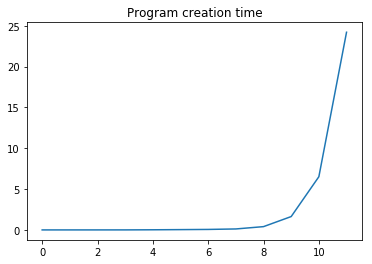

In [170]:
from time import time
import matplotlib.pyplot as plt
times = []

for x in range(2,14):
    start = time()
    LOOKUP(x)
    end = time()
    times.append(end - start)
plt.plot(times)
plt.title('Program creation time')
plt.show()

In [ ]:
x = ['110','010','001']
s = OUT2CIRC(x)
EVAL_CIRC(s, '11')

In [ ]:
def remove_duplicates(lst):
    res = []
    for elt in lst:
        if elt not in res:
            res.append(elt)
    return res

In [177]:
state_list = ['x','y']
alphabet = ['a','b']
d = {('x','a') : ('x', 'a', 'L'), ('y','a') : ('y', 'b', 'R'), ('x','b') : ('x', 'b', 'H'), ('y', 'b') : ('x', 'b', 'S')}
TM = NAND_TM(state_list, alphabet, d)
TM.transition2str()
tm = TM.tm2str()
num_states, tm = get_prefix(tm)
num_symbols, tm = get_prefix(tm)
print(num_states, num_symbols)

2 2


TypeError: 'str' object does not support item assignment

0
2


77
256


a
b


24
12
0123
0213
0312
1023
1203
1302
2013
2103
2301
3012
3102
3201


[2, 1, 2, 3]